In [15]:
import os
import cv2

import numpy as np
import pandas as pd
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


import matplotlib.pyplot as plt
from shapely.geometry import box
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib2 import Path

import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask

from osgeo import gdal
import geopandas as gpd
import shapefile as shp
import fiona
from osgeo import ogr

from mlib import *

In [10]:
root  = Path(r'L:\Satellite\prepared')

places = ['CHANDPASHA', 'SAYES', 'ULAL', 'USAR', 'USAU']
dates  = ['20190310', '20190402', '20190714', '20191005']
stypes = ['RGB', 'Sentinel', 'Planet']
suffix = 'Whole'

sent_wl = [492.1, 559.0, 665.0, 703.8, 739.1, 779.7, 833.0, 864.0, 1610.4, 2185.7]
planet_wl = [485, 545, 630, 820]
rgb_wl = [625, 545, 455]

sent_bw = [66, 36, 31, 16, 15, 20, 106, 22, 94, 185]
planet_bw = [60, 90, 80, 80]
rgb_bw = [100, 100, 100]

sent_mean = [46.8, 60.7, 47.0, 67.6, 101.3, 98.7, 100.7, 105.6, 102.1, 60.2]
planet_mean = [26.4, 29.7, 15.2, 94.6]
rgb_mean = [80.0, 83.4, 55.3]

sent_std = [20.0, 24.4, 22.5, 22.1, 29.0, 29.1, 31.8, 31.0, 29.8, 21.4]
planet_std = [27.6, 27.5, 16.1, 72.3]
rgb_std = [56.7, 55.9, 42.2]

info = dot_dict.dotdict({'root':str(root), 'places':places, 'dates':dates, 
                         'stypes':stypes, 'suffix':suffix, 'sent_wl':sent_wl,
                         'planet_wl':planet_wl, 'rgb_wl':rgb_wl, 
                         'sent_bw':sent_bw, 'planet_bw':planet_bw, 'rgb_bw':rgb_bw,
                         'sent_mean':sent_mean, 'planet_mean':planet_mean, 'rgb_mean':rgb_mean,
                         'sent_std':sent_std, 'planet_std':planet_std, 'rgb_std':rgb_std})

mio.dump(dict(info), '../dataset/info.pkl')

In [3]:
info=mio.load('../dataset/info.pkl')

In [4]:
eee=dot_dict.dotdict({})
eee.p='e'
print(eee)

{'p': 'e'}


In [5]:
te=torch.tensor([1,2,3,4,5,6])
te[0].repeat(3)

tensor([1, 1, 1])

In [6]:
# pidx  = 0
# place = places[pidx]
# didx  = 0
# date  = dates[didx]
# sidx  = 2
# stype = stypes[sidx]

# data_name = f'{date}_{stype}_{suffix}' if suffix is not None else f'{date}_{stype}'
# data_root = root / place / data_name
# if data_root.exists():
#     data_path = str(data_root / (data_name+'.tif'))
# else:
#     pass

# print(data_path)

In [7]:
def load_raster(info, indexs, use_pkl=True):
    if indexs[2] == -1:
        indexs[2] = 0
        suf = '_lr'
    else:
        suf = ''
    try:
        place = info.places[indexs[0]]
        date  = info.dates[indexs[1]]
        stype = info.stypes[indexs[2]]
    except IndexError:
        return None
    data_name = f'{date}_{stype}_{info.suffix}' if info.suffix is not None else f'{date}_{stype}'
    data_root = Path(info.root) / place / data_name
    if data_root.exists():
        if use_pkl:
            data_path = str(data_root / (data_name+suf+'.pkl'))
            with open(data_path, 'rb') as f:
                pkl_img = pkl.load(f)
            return pkl_img
        else:
            data_path = str(data_root / (data_name+'.tif'))
            return rio.open(data_path).read().transpose(1,2,0)
    else:
        return None

def check_files(info):
    valid_idxs = []
    for i in range(len(info.places)):
        for j in range(len(info.dates)):
            place = info.places[i]
            date  = info.dates[j]
            stype = info.stypes[0]
            data_name = f'{date}_{stype}_{info.suffix}' if info.suffix is not None else f'{date}_{stype}'
            data_root = Path(info.root) / place / data_name
            if data_root.exists():
                valid_idxs.append([i,j])
    return valid_idxs

def wrap_raster(raster):
    return raster.read().transpose(1,2,0)

In [8]:
class GIOSet(Dataset):
    def __init__(self, info, transforms=transforms.ToTensor()):
        self.info = info
        self.transforms = transforms
        self.index_list = check_files(self.info)

    def __len__(self):
        return len(self.index_list)

    def __getitem__(self, idx):
        indexs = self.index_list[idx]
        
        rgb_lr = load_raster(self.info, indexs+[-1,])
        rgb = load_raster(self.info, indexs+[0,])
        sentinel = load_raster(self.info, indexs+[1,])
        planet = load_raster(self.info, indexs+[2,])

        # rgb, sentinel, planet = list(map(wrap_raster, (rgb, sentinel, planet)))
        if transforms:
            rgb_lr, rgb, sentinel, planet = list(map(self.transforms, (rgb_lr, rgb, sentinel, planet)))

        return rgb_lr, rgb, sentinel, planet

In [11]:
gioset = GIOSet(info)
print(len(gioset))

6


In [12]:
rgb_lr, rgb, sentinel, planet = gioset[0]

In [14]:
rgb_lr.shape

torch.Size([3, 56, 49])

In [18]:
rgb_lr_small = F.interpolate(rgb_lr.unsqueeze(0), scale_factor=0.33)
print(rgb_lr_small.shape)

torch.Size([1, 3, 18, 16])


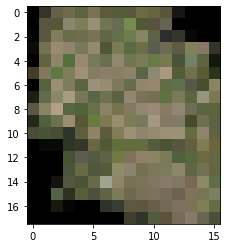

In [19]:
plt.imshow(rgb_lr_small.numpy()[0].transpose(1,2,0))

In [23]:
data = rio.open(data_path)

NameError: name 'data_path' is not defined

In [34]:
data.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 166,
 'height': 189,
 'count': 4,
 'crs': CRS.from_dict(init='epsg:3106'),
 'transform': Affine(3.0, 0.0, 533923.7983468564,
        0.0, -3.0, 2521468.8860234106)}

(4, 189, 166)


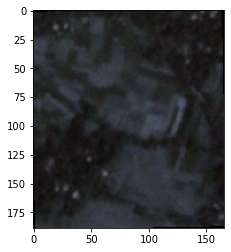

In [31]:
data_array = data.read()
print(data_array.shape)
plt.imshow(data_array[:3,:,:].transpose(1,2,0))

# Fourier Transformation

In [56]:
def fft(img):
    return np.fft.fft2(img)
def fftshift(img):
    return np.fft.fftshift(fft(img))
def ifft(img):
    return np.fft.ifft2(img)
def ifftshift(img):
    return ifft(np.fft.ifftshift(img))
def mask(img,rate = 0.1):  # 产生一个滤波矩阵     
    mask = np.ones(img.shape) # 创建全是1的与原图大小相同的矩阵     
    rows,cols = img.shape# 图片的长宽     
    mask[int(rows/2-rows*rate):int(rows/2+rows*rate),int(cols/2-cols*rate):int(cols/2+cols*rate)] = 0 # 使中心方块区域成为0
    return mask

def highpass(img, rate=0.1):
    img_fft  = fftshift(img)
    img_ifft = ifftshift(img_fft*mask(img_fft, rate))
    return np.abs(img_ifft)

In [78]:
planet.numpy().transpose(1,2,0).shape

(168, 147, 4)

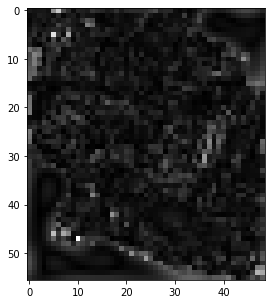

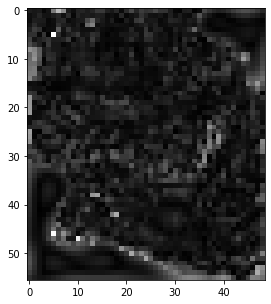

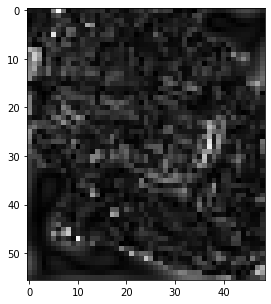

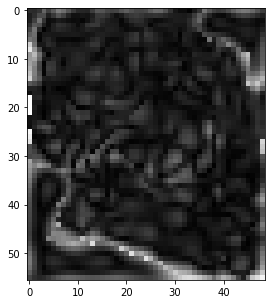

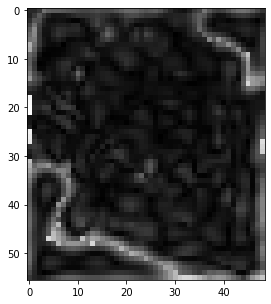

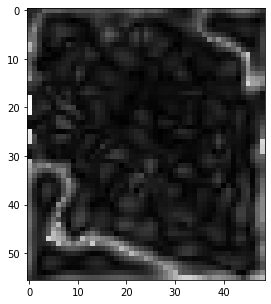

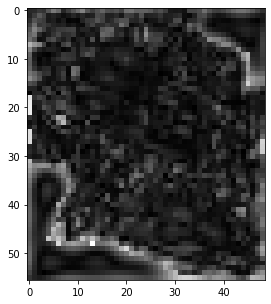

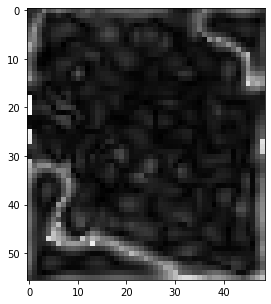

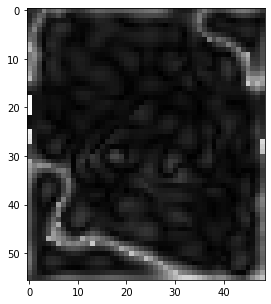

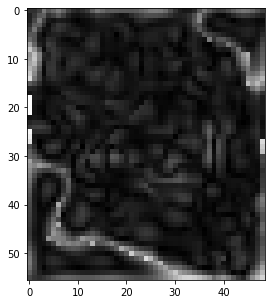

In [84]:
def show_pass(img, rate=0.1, figsize=(8,8), original=False):
    img = img.transpose(2,0,1)
    img_filtered = []
    for i in range(img.shape[0]):
        band_filtered = highpass(img[i], rate)
        img_filtered.append(band_filtered)
        plt.figure(figsize=figsize)
        if original:
            plt.imshow(img[i], cmap='gray')
        else:
            plt.imshow(band_filtered, cmap='gray')

show_pass(sentinel.numpy().transpose(1,2,0), rate=0.1, figsize=(5,5), original=False)

In [54]:
len(band_filtered)

168

In [72]:
for i in range(1,len(img_filtered)):
    err=(np.abs(planet[0]-planet[i])).sum().numpy()
    err_f=(np.abs(img_filtered[0]-img_filtered[i])).sum()
    print(round(err_f/err,3), round(err_f,3))

0.34 25227.818
0.202 26969.391
0.082 140402.543


In [42]:
ifft(img_fft)

array([[-1.07057220e-16+5.82624328e-18j,  1.42742960e-16-5.65024218e-17j,
        -9.51619735e-17+6.74063979e-17j, ...,
         0.00000000e+00+5.15460690e-17j,  1.58603289e-17-5.94762335e-17j,
         7.93016446e-17+4.36159045e-17j],
       [ 1.07057220e-16+8.25384464e-18j, -6.34413157e-17+7.93016446e-18j,
        -3.50043550e-02+4.51331180e-03j, ...,
         9.91270558e-18-1.98254112e-17j, -4.36159045e-17-7.93016446e-18j,
         7.93016446e-18-1.38777878e-17j],
       [-1.34812796e-16-2.19293323e-17j,  1.11022302e-16-5.94762335e-18j,
         1.78911144e-01-2.30680375e-02j, ...,
        -7.93016446e-17+1.58603289e-17j,  5.15460690e-17+6.34413157e-17j,
         1.24900090e-16+0.00000000e+00j],
       ...,
       [ 0.00000000e+00+3.52033272e-17j, -1.58603289e-16+2.57730345e-17j,
         6.34413157e-17-3.96508223e-18j, ...,
         3.50281904e-01+6.82173946e-02j, -5.25065329e-01-6.76996774e-02j,
         6.77037482e-01+4.34672485e-02j],
       [ 1.58603289e-17-4.33087716e-17j,  1.